In [94]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import pywt
import ctypes
import bitarray
import struct
import util
import encoding
from bitstring import BitArray
%matplotlib inline

In [95]:
def plot_image(r, g, b, cmap='gray'):
    plt.clf()
    plt.subplot(3,1,1)
    plt.imshow(r, cmap=cmap)
    plt.subplot(3,1,2)
    plt.imshow(g, cmap=cmap)
    plt.subplot(3,1,3)
    plt.imshow(b, cmap=cmap)
    plt.draw()
    plt.show()

def ims(x):
    plt.clf()
    plt.imshow(x, cmap='gray')
    plt.draw()
    plt.show()

In [352]:
im = Image.open("../final/calBlue.tiff") #Can be many different formats.
pix = im.load()
print im.size #Get the width and hight of the image for iterating over
# print pix[x,y] #Get the RGBA Value of the a pixel of an image
width, height = im.size

(52, 42)


In [353]:
import colormath

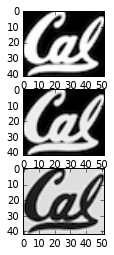

In [354]:
r = np.array(im.getdata(0)).reshape(height, width)
g = np.array(im.getdata(1)).reshape(height, width)
b = np.array(im.getdata(2)).reshape(height, width)
plot_image(r, g, b)

In [100]:
from colormath.color_objects import LabColor, sRGBColor
from colormath.color_conversions import convert_color

rgb = sRGBColor(0.2, 0.3, 0.5)
lab = convert_color(rgb, LabColor)

lab.lab_l

32.89038736919341

In [103]:
transform = np.matrix('.299, .587, .114; -.16874, -.33126, .5; .5, -.41869, -.08131')
Y = np.zeros(np.shape(r));
Cb = np.zeros(np.shape(r));
Cr = np.zeros(np.shape(r));

for i in range(np.shape(r)[0]):
    if i % 100 == 0:
        print(i)
    for j in range(np.shape(r)[1]):
        RGB = np.matrix('{0}; {1}; {2}'.format(r.item((i,j)), g.item((i,j)), b.item((i,j))));
        YCbCr = transform * RGB;
        Y[i,j] = YCbCr.item(0,0);
        Cb[i,j] = YCbCr.item(1,0);       
        Cr[i,j] = YCbCr.item(2,0);        
        
        

0
100
200
300
400
500
600
700
800
900


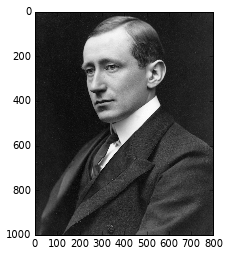

In [104]:
plt.clf()
plt.imshow(Y, cmap='gray')
plt.draw()

In [174]:
pywt.wavelist()

['bior1.1',
 'bior1.3',
 'bior1.5',
 'bior2.2',
 'bior2.4',
 'bior2.6',
 'bior2.8',
 'bior3.1',
 'bior3.3',
 'bior3.5',
 'bior3.7',
 'bior3.9',
 'bior4.4',
 'bior5.5',
 'bior6.8',
 'coif1',
 'coif2',
 'coif3',
 'coif4',
 'coif5',
 'db1',
 'db2',
 'db3',
 'db4',
 'db5',
 'db6',
 'db7',
 'db8',
 'db9',
 'db10',
 'db11',
 'db12',
 'db13',
 'db14',
 'db15',
 'db16',
 'db17',
 'db18',
 'db19',
 'db20',
 'dmey',
 'haar',
 'rbio1.1',
 'rbio1.3',
 'rbio1.5',
 'rbio2.2',
 'rbio2.4',
 'rbio2.6',
 'rbio2.8',
 'rbio3.1',
 'rbio3.3',
 'rbio3.5',
 'rbio3.7',
 'rbio3.9',
 'rbio4.4',
 'rbio5.5',
 'rbio6.8',
 'sym2',
 'sym3',
 'sym4',
 'sym5',
 'sym6',
 'sym7',
 'sym8',
 'sym9',
 'sym10',
 'sym11',
 'sym12',
 'sym13',
 'sym14',
 'sym15',
 'sym16',
 'sym17',
 'sym18',
 'sym19',
 'sym20']

In [338]:
LEVEL = 5
WAVELET = 'db3'

def get_wavelets(data, wavelet=WAVELET, lev=LEVEL, thres=None):

    wp = pywt.WaveletPacket2D(data=data, wavelet=wavelet, maxlevel=lev, mode='sym')

    #wps = sorted(wp.get_level(lev), key=lambda x: x.path)
    wps = wp.get_level(lev)

    dec = list(map(lambda x: x.data, wps))
    paths = list(map(lambda x: x.path, wps))

    if thres == None:
        thres = np.sqrt(np.mean(np.square(data)))

    for d in dec:
        dd = np.float32(d)
        dd[abs(dd) < thres] = 0

    return zip(paths, dec)
        

def encode_wavelets(waves):
    out = []
    
    for path, coefs in waves:
        
        for i in range(coefs.shape[0]):
            for j in range(coefs.shape[1]):
                b = binary_short_byte(np.round(np.clip(coefs[i,j], -2**15, 2**15)))
                out.append(b)

    drows, dcols = coefs.shape
    
    bb = ''.join(out)
    bb = binary_short_byte(drows) + binary_short_byte(dcols) + bb

    a = bitarray.bitarray(endian='big')
    a.frombytes(bb)
    
    return a

def decode_wavelets(uncompressed):
    wp3 = pywt.WaveletPacket2D(data=np.zeros((100,100)), wavelet=wav, maxlevel=lev, mode='sym')
    paths = map(lambda x: x.path, wp3.get_level(5))

#     drows = bitstoint(bitarraytostring(uncompressed[:16]))
#     dcols = bitstoint(bitarraytostring(uncompressed[16:32]))

    drows = byte_to_short(uncompressed[:16].tobytes())
    dcols = byte_to_short(uncompressed[16:32].tobytes())

    
    uncompressed = uncompressed[32:]
    
    wp2 = pywt.WaveletPacket2D(data=None, wavelet=wav, maxlevel=lev, mode='sym')

    N = 16
    
    coeff = np.zeros(len(uncompressed)/N)
    for i in range(len(uncompressed) /N):
#         coeff[i] = bitstoint(bitarraytostring(uncompressed[N*i:N*(i+1)]))
        coeff[i] = byte_to_short(uncompressed[N*i:N*(i+1)].tobytes())

    d = np.zeros((drows, dcols))
    i, j = 0, 0
    pindex = 0
    n = 0
    while pindex < len(paths):
        d[i,j] = coeff[n]
        j += 1
        n += 1
        if j >= dcols:
            j = 0
            i += 1
        if i >= drows:
            i, j = 0, 0
            wp2[paths[pindex]] = np.copy(d)
            pindex += 1

    return wp2

def bitstoint(bits):
    a = BitArray();
    a.bin = bits;
    return a.int;

def bitarraytostring(bitarray):
    return bitarray.to01()

def binary(num):
    return ''.join(bin(ord(c)).replace('0b', '').rjust(8, '0') for c in struct.pack('!f', num))

def binary_short(num):
    return ''.join(bin(ord(c)).replace('0b', '').rjust(8, '0') for c in struct.pack('!h', num))

def binary_int(num):
    return ''.join(bin(ord(c)).replace('0b', '').rjust(8, '0') for c in struct.pack('!i', num))

def binary_short_byte(num):
    return struct.pack('!h', num)

def byte_to_short(byte):
    return struct.unpack('!h', byte)[0]



def bitstofloat(bits):
    a = BitArray();
    a.bin = bits;
    return a.float;



In [339]:
waves = get_wavelets(Y)
encoded = encode_wavelets(waves)
bits = bitarray.bitarray(encoded)
wp = decode_wavelets(bits)

In [341]:
print(byte_to_short('a0'))

24880


In [342]:
len(binary_short(8000))

16

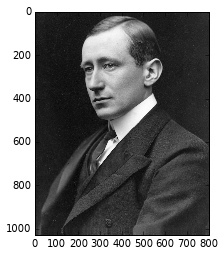

In [343]:
ims(wp.reconstruct())

In [330]:
a = bitarray.bitarray(endian='big')
a.frombytes('a')
a.tobytes()

'a'

In [344]:
def encode_cartoon(rgb):
    bytea = bytearray(rgb.flatten())
    bitar = bitarray.bitarray()
    bitar.frombytes(str(bytea))
    return util.compress(bitar)


In [235]:
bitstoint(encoding.binary_short(23200))

23200

77.2442318738
4558
234.544975867


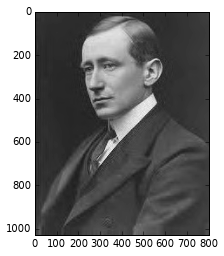

In [295]:
x = Y

lev = 5
wav = 'db3'

wp = pywt.WaveletPacket2D(data=x, wavelet=wav, maxlevel=lev, mode='sym')

wps = wp.get_level(lev)

dec = map(lambda x: x.data, wps)
paths = map(lambda x: x.path, wps)

data = np.vstack(dec)
s = np.std(data)

wp3 = pywt.WaveletPacket2D(data=None, wavelet=wav, maxlevel=lev, mode='sym')


#thres = 100
thres = np.sqrt(np.mean(np.square(Y)))
print(thres)

res = 0

for p, d in zip(paths, dec):
    dd = np.copy(d)
    #dd[abs(d - np.mean(d)) < thres] = np.mean(d)
#     m = dd.mean()
    #dd = np.round((dd - m)/10.0)*10 + m
    dd[abs(d) < thres] = 0
    if np.sum(dd != 0) > 0:
        dd = np.clip(np.round(dd), -2**15, 2**15)
    wp3[p] = dd
    res += np.sum(dd != 0)




print(res)
print(float(data.size) / float(res))


ims(wp3.reconstruct())

In [ ]:
## tCr = wp3.reconstruct()[:height, :width]

In [202]:
pp = ['a', 'h', 'v', 'd']
levs = [a+b+c+d for a in pp for b in pp for c in pp for d in pp]
#map(lambda x: x.path, sorted(wp3.get_level(3), key=lambda x: x.path))

In [167]:
wp3['dddd']

In [426]:
bitarray.bitarray('1001') + bitarray.bitarray('1000001')

bitarray('10011000001')

In [427]:
def binary_int_byte(num):
    return struct.pack('!i', num)

def byte_to_int(byte):
    return struct.unpack('!i', byte)[0]


In [435]:
byte_to_int(binary_int_byte(-10000))

-10000

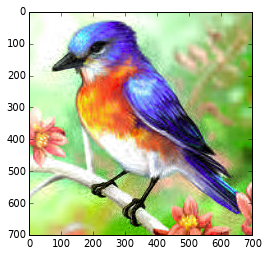

In [39]:
trgb = np.dstack((tR, tG, tB))
ims(trgb)

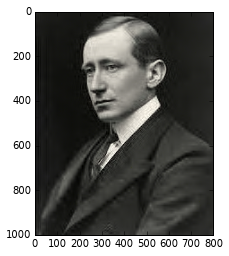

In [119]:
tycbcr = np.dstack((tY, Cb, tCr))
trgb = encoding.ycbcr_to_rgb(tycbcr)
ims(np.clip(trgb, 0, 255)/256.0)


In [44]:
def binary(num):
    return ''.join(bin(ord(c)).replace('0b', '').rjust(8, '0') for c in struct.pack('!f', num))

def bitstofloat(bits):
    a = BitArray();
    a.bin = bits;
    return a.float;

def bitarraytostring(bitarray):
    nums = np.array(bitarray);
    output = '';
    for num in nums:
        fixed = bin(num);
        if len(fixed) > 9:
            fixed = fixed.replace('0b', '');
        elif len(fixed) < 9:
            fixed = fixed.replace('b', '0'*(9-len(fixed)));
        else:
            fixed = fixed.replace('b', '');
        output += fixed;
    return output

def compressandencode(name, lev = 4, wav = 'db3', thres = 500):
    im = Image.open(name)
    width, height = im.size
    
    print 'Found image with width {0} and height {1}'.format(width, height);
    
    r = np.array(im.getdata(0)).reshape(height, width)
    g = np.array(im.getdata(1)).reshape(height, width)
    b = np.array(im.getdata(2)).reshape(height, width)
    
    transform = np.matrix('.299, .587, .114; -.16874, -.33126, .5; .5, -.41869, -.08131')
    Y = np.zeros(np.shape(r));
    Cb = np.zeros(np.shape(r));
    Cr = np.zeros(np.shape(r));
    
    for i in range(np.shape(r)[0]):
        for j in range(np.shape(r)[1]):
            RGB = np.matrix('{0}; {1}; {2}'.format(r.item((i,j)), g.item((i,j)), b.item((i,j))));
            YCbCr = transform * RGB;
            Y[i,j] = YCbCr.item(0,0);
            Cb[i,j] = YCbCr.item(1,0);       
            Cr[i,j] = YCbCr.item(2,0);
            
    print 'Finished transform to Y, Cb, Cr';
    
    x = Y

    wp = pywt.WaveletPacket2D(data=x, wavelet=wav, maxlevel=lev, mode='sym')

    wps = wp.get_level(lev)

    dec = map(lambda x: x.data, wps)
    
    print 'Got coefficients';
            
    uncompressed = '';
    for d in dec:
        dd = np.float32(d);
        dd[abs(d) < thres] = 0;
        for i in range(np.shape(dd)[0]):
            for j in range(np.shape(dd)[1]):
                uncompressed += binary(dd[i][j]);
    
    drows, dcols = np.shape(dec[0])
    uncompressed = binary(drows) + binary(dcols) + uncompressed;

    compressed = util.compress(np.array(uncompressed));
    
    print 'Compressed to {0} bits'.format(len(compressed));
    
    return compressed;

def decompressanddecode(compressed):
    
    paths = ['aaaa', 'aaah', 'aaav', 'aaad', 'aaha', 'aahh', 'aahv', 'aahd', 'aava', 'aavh', 'aavv', 'aavd', 'aada', 'aadh', 'aadv', 'aadd',
     'ahaa', 'ahah', 'ahad', 'ahha', 'ahhh', 'ahhv', 'ahhd', 'ahva', 'ahvh', 'ahvv', 'ahvd', 'ahda', 'ahdh', 'ahdv', 'ahdd', 'avaa', 'avah',
     'avav', 'avad', 'avha', 'avhh', 'avhv', 'avhd', 'avva', 'avvh', 'avvv', 'avvd', 'avda', 'avdh', 'avdv', 'avdd', 'adaa', 'adah', 'adav',
     'adad', 'adha', 'adhh', 'adhv', 'adhd', 'adva', 'advh', 'advv', 'advd', 'adda', 'addh', 'addv', 'addd', 'haaa', 'haah', 'haav', 'haad', 
     'haha', 'hahh', 'hahv', 'hahd', 'hava', 'havh', 'havv', 'havd', 'hada', 'hadh', 'hadv', 'hadd', 'hhaa', 'hhah', 'hhav', 'hhad', 'hhha',
     'hhhh', 'hhhv', 'hhhd', 'hhva', 'hhvh', 'hhvv', 'hhvd', 'hhda', 'hhdh', 'hhdv', 'hhdd', 'hvaa', 'hvah', 'hvav', 'hvad', 'hvha', 'hvhh',
     'hvhv', 'hvhd', 'hvva', 'hvvh', 'hvvv', 'hvvd', 'hvda', 'hvdh', 'hvdv', 'hvdd', 'hdaa', 'hdah', 'hdav', 'hdad', 'hdha', 'hdhh', 'hdhv',
     'hdhd', 'hdva', 'hdvh', 'hdvv', 'hdvd', 'hdda', 'hddh', 'hddv', 'hddd', 'vaaa', 'vaah', 'vaav', 'vaad', 'vaha', 'vahh', 'vahv', 'vahd',
     'vava', 'vavh', 'vavv', 'vavd', 'vada', 'vadh', 'vadv', 'vadd', 'vhaa', 'vhah', 'vhav', 'vhad', 'vhha', 'vhhh', 'vhhv', 'vhhd', 'vhva',
     'vhvh', 'vhvv', 'vhvd', 'vhda', 'vhdh', 'vhdv', 'vhdd', 'vvaa', 'vvah', 'vvav', 'vvad', 'vvha', 'vvhh', 'vvhv', 'vvhd', 'vvva', 'vvvh',
     'vvvv', 'vvvd', 'vvda', 'vvdh', 'vvdv', 'vvdd', 'vdaa', 'vdah', 'vdav', 'vdad', 'vdha', 'vdhh', 'vdhv', 'vdhd', 'vdva', 'vdvh', 'vdvv',
     'vdvd', 'vdda', 'vddh', 'vddv', 'vddd', 'daaa', 'daah', 'daav', 'daad', 'daha', 'dahh', 'dahv', 'dahd', 'dava', 'davh', 'davv', 'davd',
     'dada', 'dadh', 'dadv', 'dadd', 'dhaa', 'dhah', 'dhav', 'dhad', 'dhha', 'dhhh', 'dhhv', 'dhhd', 'dhva', 'dhvh', 'dhvv', 'dhvd', 'dhda',
     'dhdh', 'dhdv', 'dhdd', 'dvaa', 'dvah', 'dvav', 'dvad', 'dvha', 'dvhh', 'dvhv', 'dvhd', 'dvva', 'dvvh', 'dvvv', 'dvvd', 'dvda', 'dvdh',
     'dvdv', 'dvdd', 'ddaa', 'ddah', 'ddav', 'ddad', 'ddha', 'ddhh', 'ddhv', 'ddhd', 'ddva', 'ddvh', 'ddvv', 'ddvd', 'ddda', 'dddh', 'dddv',
     'dddd']
    uncompressed = util.decompress(compressed);
    drows = int(bitstofloat(bitarraytostring(uncompressed[32*0:32*0+32])));
    dcols = int(bitstofloat(bitarraytostring(uncompressed[32*1:32*1+32])));
    uncompressed = uncompressed[32*2:];
    
    numCoeff = len(uncompressed) / 32 / 256
    lev = 4
    wav = 'db3'
    wp2 = pywt.WaveletPacket2D(data=None, wavelet=wav, maxlevel=lev, mode='sym')

    coeff = np.zeros(len(uncompressed)/32)
    for i in range(len(uncompressed) / 32):
        coeff[i] = bitstofloat(bitarraytostring(uncompressed[32*i:32*i+32]))

    for pindex in range(len(paths)):
        wp2[paths[pindex]] = np.reshape(coeff[drows*dcols*pindex:drows*dcols*(pindex+1)], (drows, dcols));
    #for pindex in range(len(paths)):
    #    dd = np.zeros((drows, dcols));
    #    for i in range(drows*dcols):
    #       dd[int(np.floor(i/dcols))][i%drows] = coeff[drows*dcols*pindex + i];
    #    wp2[paths[pindex]] = dd;

    ims(wp2.reconstruct())

In [10]:
compressedbird = compressandencode('Marconi.tiff')

Found image with width 800 and height 1000
Finished transform to Y, Cb, Cr
Got coefficients


KeyboardInterrupt: 

In [ ]:
import time
start_time = time.time()
decompressanddecode(compressedbird)
print time.time() - start_time

In [ ]:
def dandd(compressed):

In [ ]:
x = np.array(compressedbird.tolist());

In [ ]:
length = 0;
thres = 100;
for d in dec:
    dd = np.float32(d);
    dd[abs(d) < thres] = 0;
    indicesrow, indicescol = np.nonzero(dd);
    count = len(indicesrow);
    output = binary(count);
    for row, col in zip(indicesrow, indicescol):
        output += binary(row) + binary(col);
        output += binary(dd[row][col]);
    length += util.compress(np.array(output))
    
print length
        
        
    
    
    

In [ ]:
thres = 500;

uncompressed = '';
for d in dec:
    dd = np.float32(d);
    dd[abs(d) < thres] = 0;
    
    flattened = np.ndarray.flatten(dd);
    for coeff in flattened:
        uncompressed += binary(coeff);
    """for i in range(np.shape(dd)[0]):
        for j in range(np.shape(dd)[1]):
            uncompressed += binary(dd[i][j]);"""

drows, dcols = np.shape(dec[0])
uncompressed = binary(drows) + binary(dcols) + uncompressed;

compressed = util.compress(np.array(uncompressed));
    
print len(compressed)

In [ ]:
uncompressed = util.decompress(compressed)
drows = int(bitstofloat(bitarraytostring(uncompressed[32*0:32*0+32])));
dcols = int(bitstofloat(bitarraytostring(uncompressed[32*1:32*1+32])));
uncompressed = uncompressed[32*2:];

numCoeff = len(uncompressed) / 32 / 256
lev = 4
wav = 'db3'
wp2 = pywt.WaveletPacket2D(data=None, wavelet=wav, maxlevel=lev, mode='sym')

coeff = np.zeros(len(uncompressed)/32)
for i in range(len(uncompressed) / 32):
    coeff[i] = bitstofloat(bitarraytostring(uncompressed[32*i:32*i+32]))

for pindex in range(len(paths)):
    wp2[paths[pindex]] = np.reshape(coeff[drows*dcols*pindex:drows*dcols*(pindex+1)], (drows, dcols));
    
    #dd = np.zeros((drows, dcols));
    #for i in range(drows*dcols):
    #    dd[int(np.floor(i/dcols))][i%dcols] = coeff[drows*dcols*pindex + i];
    #wp2[paths[pindex]] = dd;
    
ims(wp2.reconstruct())

In [376]:
import zlib
def compress(npa):
    """takes in a bitarray (length multiple 8), returns it compressed, as a bitarray"""
    bita = bitarray.bitarray(npa.tolist())
    bytea = bytearray(bita)
    compressed = zlib.compress(str(bytea), 9)
    bitar = bitarray.bitarray()
    bitar.frombytes(compressed)
    return bitar

def decompress(npa):
    """takes in a compressed bitarray (length multiple 8), returns bitarray"""
    bytea = bytearray(npa)
    decompressed = zlib.decompress(str(bytea))
    bitar = bitarray.bitarray()
    bitar.frombytes(decompressed)
    return bitar


In [421]:

def encode_cartoon(rgb):
    bytea = bytearray(np.int8(rgb.flatten()))
    bitar = bitarray.bitarray()

    bb = binary_short_byte(height) + binary_short_byte(width) + \
         str(bytea)
    bitar.frombytes(bb)
    
    return compress(bitar)

def decode_cartoon(compressed):
    uncompressed = decompress(compressed)
    print(len(uncompressed)/8)
    height = byte_to_short(uncompressed[:16].tobytes())
    width = byte_to_short(uncompressed[16:32].tobytes())
    rgb = np.array(bytearray(uncompressed[32:]))
    print(height, width)
    print(rgb.size)
    return rgb.reshape((height, width, 3))


In [422]:
x = encode_cartoon(np.dstack([r,g,b]))

6556
(42, 52)
6552


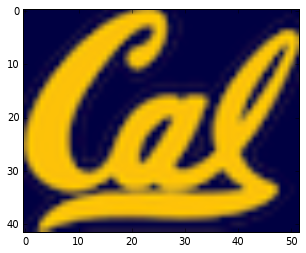

In [424]:
ims(decode_cartoon(x))

In [402]:
42 * 52  * 3

6552